## Himanshu Baweja

## E20CSE212

## Week 10 Lab 2

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
import numpy as np

In [2]:
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

# complete the below statement(s). Take parameter subset="all" 
dataset = fetch_20newsgroups(subset='all', categories=categories, 
                             shuffle=False, remove=('headers', 'footers', 'quotes'))
labels = dataset.target
true_k = np.unique(labels).shape[0]

vectorizer = TfidfVectorizer()

data_tfidf = vectorizer.fit_transform(dataset.data)

In [3]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N) using randint.
    rand_indices = np.random.randint(0, n, k)
    
   
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

In [4]:
data_tfidf.shape

(3387, 33836)

In [5]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = data_tfidf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(data_tfidf, queries, metric='euclidean')

print(dist)

[[1.38066901 1.        ]
 [1.35581767 1.        ]
 [1.37696773 1.        ]
 ...
 [1.39380324 1.        ]
 [1.35955448 1.        ]
 [1.37841014 1.        ]]


In [6]:
dist.shape

(3387, 2)

In [7]:
closest_cluster = np.argmin(dist, axis = 1)
closest_cluster

array([1, 1, 1, ..., 1, 1, 1])

In [8]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data, centroids, metric='euclidean')

    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    cluster_assignment = np.argmin(distances_from_centroids, axis = 1)
    
    return cluster_assignment

In [9]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

In [10]:
cluster_assignment = assign_clusters(data, centroids)
print(cluster_assignment)

[0 1 0]


In [11]:
cluster_assignment==1

array([False,  True, False])

In [12]:
cluster_assignment==0

array([ True, False,  True])

In [13]:
data[cluster_assignment==1]

array([[0., 0., 0.]])

In [14]:
data[cluster_assignment==1]

array([[0., 0., 0.]])

In [15]:
data[cluster_assignment==0].mean(axis=0)

array([1.5, 2. , 0. ])

In [16]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = data[cluster_assignment==i].mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [17]:
result = revise_centroids(data_tfidf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(data_tfidf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(data_tfidf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(data_tfidf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check your code')

Pass


In [18]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

In [19]:
compute_heterogeneity(data, 2, centroids, cluster_assignment)

7.25

In [20]:
# Fill in the blanks
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # YOUR CODE HERE
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # YOUR CODE HERE
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # YOUR CODE HERE
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

In [21]:
import matplotlib.pyplot as plt

In [22]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
      785 elements changed their cluster assignment.
2
      452 elements changed their cluster assignment.
3
      216 elements changed their cluster assignment.
4
      121 elements changed their cluster assignment.
5
       74 elements changed their cluster assignment.
6
       38 elements changed their cluster assignment.
7
       25 elements changed their cluster assignment.
8
       22 elements changed their cluster assignment.
9
       17 elements changed their cluster assignment.
10
       16 elements changed their cluster assignment.
11
       11 elements changed their cluster assignment.
12
        7 elements changed their cluster assignment.
13
        4 elements changed their cluster assignment.
14
        5 elements changed their cluster assignment.
15
        3 elements changed their cluster assignment.
16
        2 elements changed their cluster assignment.
17
        3 elements changed their cluster assignment.
18
        1 elements changed their cluster assignment.

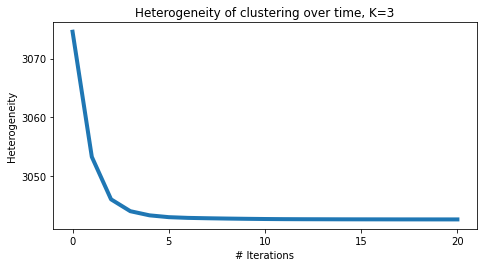

In [23]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(data_tfidf, k, seed=0)
centroids, cluster_assignment = kmeans(data_tfidf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [24]:
import sys
k = 10
heterogeneity = {}
import time
start = time.time()
try:
  for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(data_tfidf, k, seed)
    centroids, cluster_assignment = kmeans(data_tfidf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(data_tfidf, k, centroids, cluster_assignment)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    sys.stdout.flush()
except:
  pass
end = time.time()
print(end-start)

seed=000000, heterogeneity=3005.81526
seed=020000, heterogeneity=3008.10874
seed=040000, heterogeneity=3045.28692
seed=060000, heterogeneity=3044.03155
seed=080000, heterogeneity=3010.36519
6.186365365982056
